In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import nltk

from textblob import TextBlob
from langdetect import detect
from nltk.util import ngrams
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentiText

In [535]:
with open('final_3420_english_only_comments_df.pkl', 'rb') as file:
    english_only_comments_df = pkl.load(file)

## Need to aggregate all comments per game

In [536]:
# Use this to get each unique game with platform. Since a game can be on multiple platforms.

df_pivot = pd.pivot_table(english_only_comments_df, values = ['Userscore'], index = ['Title', 'Platform'])
unique_games_platform_list = df_pivot.index

In [537]:
# Assign unique ID to each game/platform, in case we lose the index
game_id_list = []
game_list = []
platform_list = []

game_id = 0
for unique_game in unique_games_platform_list:
    game_id += 1
    game_id_list.append(game_id)
    game_list.append(unique_game[0])
    platform_list.append(unique_game[1])
    
game_id_df = pd.DataFrame()
game_id_df['game_id'] = game_id_list
game_id_df['Title'] = game_list
game_id_df['Platform'] = platform_list

game_id_df.head()

,game_id,Title,Platform
0,1,'Splosion Man,Xbox360
1,2,007: The World is Not Enough,Nintendo64
2,3,2010 FIFA World Cup South Africa,PlayStation3
3,4,2010 FIFA World Cup South Africa,Xbox360
4,5,3D After Burner II,3DS


In [538]:
# Assign unique ID to each user, in case we lose the index

users_list = set(english_only_comments_df['Username'])

user_id_list = []

user_id = 0
for user in users_list:
    user_id += 1
    user_id_list.append(user_id)
    
user_id_df = pd.DataFrame()
user_id_df['user_id'] = user_id_list
user_id_df['Username'] = users_list

user_id_df.head()

,user_id,Username
0,1,Leros
1,2,RedE.
2,3,deez
3,4,J_Cigs
4,5,Hrboe


In [539]:
# Merge game_id_df and user_id_df to original df to apply the ID's

df = pd.merge(english_only_comments_df, game_id_df, on=['Title','Platform'])
df = pd.merge(df, user_id_df, on='Username')
df = df.reindex(['game_id','Title','Platform','Userscore', 'user_id','Username','Comment','Helpfulness','Language'], axis=1)

df.head()

,game_id,Title,Platform,Userscore,user_id,Username,Comment,Helpfulness,Language
0,2815,The Legend of Zelda: Ocarina of Time,Nintendo64,10,35467,SirCaestus,"Everything in OoT is so near at perfection, it...",24,en
1,3153,Vagrant Story,PlayStation,10,35467,SirCaestus,"The complex story, the deep battle system, the...",6,en
2,918,Final Fantasy VII,PlayStation,9,35467,SirCaestus,The Story of FF VII is well known for a good r...,2,en
3,919,Final Fantasy VIII,PlayStation,10,35467,SirCaestus,This game knows how to suck you in. The Juncti...,5,en
4,2815,The Legend of Zelda: Ocarina of Time,Nintendo64,10,54276,Kaistlin,I won't bore you with what everyone is already...,27,en


In [540]:
# Aggregate all comments for each game/platform

game_id_comment_list = []
comments_for_games_list = []

for i in game_id_list:
    review_text = df[df['game_id'] == i]['Comment'].str.cat(sep=' ').strip(' ').lower()
    game_id_comment_list.append(i)
    comments_for_games_list.append(review_text)

comments_for_games_df = pd.DataFrame()
comments_for_games_df['game_id'] = game_id_comment_list
comments_for_games_df['reviews'] = comments_for_games_list

In [541]:
# Each game/platform should have a blob of text like this
comments_for_games_df['reviews'][5]

'the original genesis title is astounding as is but this new port is so well made and comes with new options unique to this version, it\'s hard to not grab it again even if you already own it somewhere else.everything you\'re expecting is here, co-op and a new game mode that lets you freely select which power ups you have as well as save states and being able to choose which regionalthe original genesis title is astounding as is but this new port is so well made and comes with new options unique to this version, it\'s hard to not grab it again even if you already own it somewhere else.everything you\'re expecting is here, co-op and a new game mode that lets you freely select which power ups you have as well as save states and being able to choose which regional version of the game you\'re playing, in addition to some other pretty great but less notable options.it\'s hard to put a fair score on this, my system is generally stuff starts out at 5 and below is if it\'s worse than average a

## Data/Text Preprocessing

Remove all punctuations

In [542]:
comments_for_games_df['reviews'] = comments_for_games_df['reviews'].str.replace('[^\w\s]',' ')

Remove stopwords

In [588]:
'''
Need to add all game titles as stopwords
'''

game_titles = list(df['Title'].unique())
lowercase_game_titles = [title.lower().split(': ') for title in game_titles]



'''
Some games has multiple sequels, such as 'Legend of Zelda: Ocarina of Time', so need to remove 'Legend of Zelda'
and 'Ocarina of Time' separately. Since many reviewers only write out a part of the game title.
'''

titles_to_remove = []
for title in lowercase_game_titles:
    if len(title) == 2:
        titles_to_remove.append(title[0])
        titles_to_remove.append(title[1])
    else:
        titles_to_remove.append(title[0])

        
# Add all titles to stopwords list

stop = stopwords.words('english')
stop.extend(titles_to_remove)


Remove common words

In [544]:
# Can add some common words into stopwords list; filtered through the top 100 common words and added to stop list
word_frequency = pd.Series(' '.join(comments_for_games_df['reviews']).split()).value_counts()

In [587]:
word_frequency[0:100]

the         2449647
and         1313113
a           1146520
to          1057650
game         981154
is           974465
of           941308
i            893068
it           879960
you          667283
this         618012
in           537763
that         515118
for          389637
but          382984
are          349251
with         341286
s            337315
t            282533
have         272523
as           268168
not          264235
on           260944
was          229750
be           209943
like         206108
all          203614
can          190600
so           183393
just         181135
             ...   
do            91780
by            90515
when          90127
played        89978
gameplay      89088
2             87619
well          84567
because       83427
don           79959
would         78776
10            78520
most          77575
other         75616
still         74479
also          74226
better        72207
playing       71912
been          71224
ever          68883


In [589]:
stop.extend(word_frequency[0:100].index)

Remove rare words

In [591]:
# Remove words that occur less than 500 times

rare_words = word_frequency[-200900:]
rare_words = list(rare_words.index)
#rare_words
stop.extend(rare_words)

In [592]:
stopword_dict = {}

for stopword in stop:
    stopword_dict[stopword] = 1

In [593]:
comments_for_games_df['reviews'] = comments_for_games_df['reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword_dict))


Lemmatization

In [595]:
from textblob import Word

comments_for_games_df['reviews'] = comments_for_games_df['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## Topic Modeling & Building Game Recommender by Text

In [597]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from gensim.models import word2vec

In [875]:
train_data_reviews = comments_for_games_df['reviews']

In [876]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(train_data_reviews)
tfidf_data = tfidf_vectorizer.fit_transform(train_data_reviews)

### Topic Modeling

In [877]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [878]:
n_comp = 20

lsa = TruncatedSVD(n_components=n_comp)

lsa_cv_data = lsa.fit_transform(cv_data)
lsa_tfidf_data = lsa.fit_transform(tfidf_data)

In [879]:
# Display topics for LSA on CountVectorizer

display_topics(lsa,count_vectorizer.get_feature_names(),15)


Topic  0
puzzle, shooter, car, battle, gun, racing, dlc, voice, issue, team, bug, kill, fight, unique, art

Topic  1
car, racing, race, forza, driving, track, racer, rally, burnout, nfs, speed, handling, career, arcade, kart

Topic  2
fifa, football, madden, pe, ea, ball, team, soccer, sport, fifa fifa, nfl, nba, passing, espn, league

Topic  3
puzzle, fifa, episode, adventure, art, platformer, solve, pe, solving, indie, football, racing, car, puzzle puzzle, platforming

Topic  4
madden, football, nfl, espn, nba, sport, ea, puzzle, franchise, madden madden, madden nfl, baseball, nhl, basketball, hockey

Topic  5
episode, cod, shooter, telltale, zombie, duty, walking dead, gun, ops, dead, horror, resident, resident evil, warfare, walking

Topic  6
episode, telltale, walking dead, final fantasy, fantasy, choice, walking, season, final, expansion, pokemon, episode episode, battle, decision, unit

Topic  7
resident, resident evil, soul, horror, evil, dark soul, dark, fighting, fighter, su

In [880]:
# Display topics for LSA on TF-IDF Vectorizer

display_topics(lsa,tfidf_vectorizer.get_feature_names(),15)


Topic  0
puzzle, shooter, car, battle, gun, racing, dlc, voice, issue, team, bug, kill, fight, unique, art

Topic  1
car, racing, race, forza, driving, track, racer, rally, burnout, nfs, speed, handling, career, arcade, kart

Topic  2
fifa, football, madden, pe, ea, ball, team, soccer, sport, fifa fifa, nfl, nba, passing, espn, league

Topic  3
puzzle, fifa, episode, adventure, art, platformer, solve, pe, solving, indie, football, racing, car, puzzle puzzle, platforming

Topic  4
madden, football, nfl, espn, nba, sport, ea, puzzle, franchise, madden madden, madden nfl, baseball, nhl, basketball, hockey

Topic  5
episode, cod, shooter, telltale, zombie, duty, walking dead, gun, ops, dead, horror, resident, resident evil, warfare, walking

Topic  6
episode, telltale, walking dead, final fantasy, fantasy, choice, walking, season, final, expansion, pokemon, episode episode, battle, decision, unit

Topic  7
resident, resident evil, soul, horror, evil, dark soul, dark, fighting, fighter, su

Let's try using NMF with the two vectorizers instead

In [881]:
n_comp = 20

nmf = NMF(n_components=n_comp)

nmf_cv_data = nmf.fit_transform(cv_data)
nmf_tfidf_data = nmf.fit_transform(tfidf_data)

In [882]:
# Display topics for NMF on CountVectorizer

display_topics(nmf,count_vectorizer.get_feature_names(),15)


Topic  0
bioware, mass effect, dragon, mass, dlc, effect, witcher, dragon age, bethesda, choice, quest, bug, age, dialogue, rpgs

Topic  1
car, racing, race, forza, track, racer, driving, rally, burnout, nfs, speed, handling, arcade, kart, career

Topic  2
fifa, pe, football, soccer, ea, ball, team, fifa fifa, goal, pro, konami, league, career, ultimate team, passing

Topic  3
puzzle, adventure, solve, solving, puzzle puzzle, art, solve puzzle, indie, tomb, simple, atmosphere, raider, tomb raider, unique, challenging

Topic  4
madden, football, nfl, ea, espn, sport, franchise, madden madden, madden nfl, team, ball, football madden, feature, ea sport, college

Topic  5
cod, shooter, duty, gun, ops, warfare, zombie, modern warfare, modern, vehicle, server, treyarch, kill, team, dice

Topic  6
episode, telltale, walking dead, walking, season, dead, choice, episode episode, decision, wolf, zombie, comic, emotional, click, adventure

Topic  7
resident, resident evil, horror, evil, survival

In [883]:
# Display topics for NMF on TF-IDF Vectorizer

display_topics(nmf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
bioware, mass effect, dragon, mass, dlc, effect, witcher, dragon age, bethesda, choice, quest, bug, age, dialogue, rpgs

Topic  1
car, racing, race, forza, track, racer, driving, rally, burnout, nfs, speed, handling, arcade, kart, career

Topic  2
fifa, pe, football, soccer, ea, ball, team, fifa fifa, goal, pro, konami, league, career, ultimate team, passing

Topic  3
puzzle, adventure, solve, solving, puzzle puzzle, art, solve puzzle, indie, tomb, simple, atmosphere, raider, tomb raider, unique, challenging

Topic  4
madden, football, nfl, ea, espn, sport, franchise, madden madden, madden nfl, team, ball, football madden, feature, ea sport, college

Topic  5
cod, shooter, duty, gun, ops, warfare, zombie, modern warfare, modern, vehicle, server, treyarch, kill, team, dice

Topic  6
episode, telltale, walking dead, walking, season, dead, choice, episode episode, decision, wolf, zombie, comic, emotional, click, adventure

Topic  7
resident, resident evil, horror, evil, survival

Let's try using LDA with the two vectorizers

In [884]:
n_comp = 20

lda = LatentDirichletAllocation(n_components=n_comp)

lda_cv_data = lda.fit_transform(cv_data)
lda_tfidf_data = lda.fit_transform(tfidf_data)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [885]:
# Display topics for LDA on CountVectorizer

display_topics(lda,count_vectorizer.get_feature_names(),30)


Topic  0
batmobile, forward pacing, child arkham, episode child, arkham significant, pacing future, say newest, puzzle comic, concept numerous, newest wanted, numerous understand, pro simplistic, simple say, guy dollar, believe treasure, state choose, food hidden, grab expecting, hidden gen, figure gamepad, unique grab, treasure land, astounding port, treasure star, maximum gamecube, evil tremendous, happens animal, tremendous caring, platformer skill, land adventure

Topic  1
suck wrote, wrote longer, longer lost, offered wasting, wasting enjoyment, enjoyment hooked, tried offered, sad accessible, jump problem, likely smooth, hooked sad, accessible jump, problem update, glad mini, tv bargain, mini bought, recommended goodness, psp mini, ign recommendation, recommendation glad, whilst tv, update likely, mini whilst, bargain hope, travel suspense, tour book, book essence, essence tour, reading ign, skill exit

Topic  2
human impossible, term factor, trip ton, favorite trip, honestly fa

dynamic stick, answer appeal, avid arcade, bigger speed, ii famous, movement bigger, gamer answer, trigger shoot, smoothly reviewer, talking surprised, plain attention, demo super, say demo, attention run, note run, table losing, patch replaced, losing iii, twist beast, op civ, hoped unique, trip present, overpowered patch, welcome vanilla, unique emphasis, iii welcome, bland expansion, japan op, gamers iii, beast unique

Topic  19
copy kick, learn draw, sport technically, wonder outstanding, technically aggressive, realize question, question extreme, aggressive stat, stat massive, sport low, basically sport, massive basically, create addictive, kick feature, lot hell, football create, messed football, atmosphere messed, cup atmosphere, apart football, create cup, experienced technique, market tho, shelf attention, tool experienced, purchasing youtube, case shelf, art purchasing, called custom, draw famous


In [886]:
# Display topics for LDA on TF-IDF Vectorizer

display_topics(lda,tfidf_vectorizer.get_feature_names(),15)


Topic  0
batmobile, forward pacing, child arkham, episode child, arkham significant, pacing future, say newest, puzzle comic, concept numerous, newest wanted, numerous understand, pro simplistic, simple say, guy dollar, believe treasure

Topic  1
suck wrote, wrote longer, longer lost, offered wasting, wasting enjoyment, enjoyment hooked, tried offered, sad accessible, jump problem, likely smooth, hooked sad, accessible jump, problem update, glad mini, tv bargain

Topic  2
human impossible, term factor, trip ton, favorite trip, honestly favor, section mistake, mistake honestly, master fine, defeat clumsy, poor defeat, offer gem, nearly poor, alright quickly, interface addictive, age alright

Topic  3
list limit, aggressive song, interact card, value interact, mode tremendous, opponent playstyle, playstyle close, rng city, city opponent, depending rng, fly depending, core strategy, strategy changed, protagonist classic, retro added

Topic  4
secret general, tool tactic, multi attempting

# Clustering

In [779]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

In [887]:
ssx_nmf_cv = StandardScaler().fit_transform(nmf_cv_data)
ssx_nmf_tfidf = StandardScaler().fit_transform(nmf_tfidf_data)

ssx_lsa_cv = StandardScaler().fit_transform(lsa_cv_data)
ssx_lsa_tfidf = StandardScaler().fit_transform(lsa_tfidf_data)

ssx_lda_cv = StandardScaler().fit_transform(lda_cv_data)
ssx_lda_tfidf = StandardScaler().fit_transform(lda_tfidf_data)

## K-Means & SSE

In [781]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

In [782]:
def get_silhouette_sse(vectorized_data, cluster_range):
    Sil_coefs = []
    SSEs = []
    
    for k in cluster_range:
        km = KMeans(n_clusters=k, random_state=25)
        km.fit(vectorized_data)
        labels = km.labels_
        Sil_coefs.append(silhouette_score(vectorized_data, labels, metric='euclidean'))
        SSEs.append(get_SSE(vectorized_data, labels))
        
    return cluster_range, Sil_coefs, SSEs

In [ ]:
# used to show silhouette scores in detail
for k in range(2,15):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(ssx_lda_cv)
    labels = km.labels_
    silhouette_avg = silhouette_score(ssx_lda_cv, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(ssx_lda_cv, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.jet(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

**NMF / CountVectorizer**

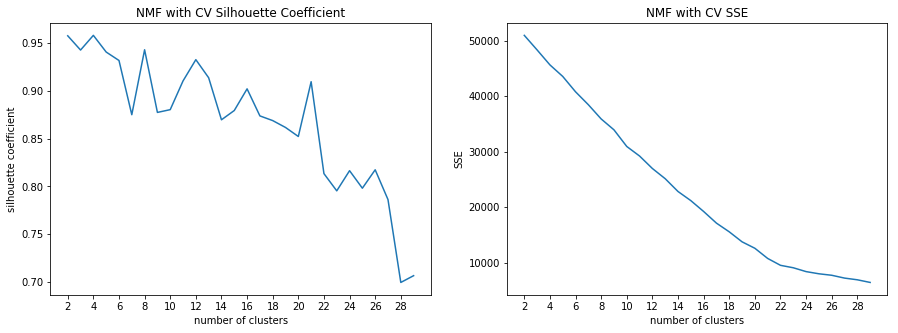

In [783]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_nmf_cv, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('NMF with CV Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('NMF with CV SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [784]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_nmf_cv)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_nmf_cv = tsne_model.fit_transform(ssx_nmf_cv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2680 samples in 0.006s...
[t-SNE] Computed neighbors for 2680 samples in 0.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2680
[t-SNE] Computed conditional probabilities for sample 2000 / 2680
[t-SNE] Computed conditional probabilities for sample 2680 / 2680
[t-SNE] Mean sigma: 0.006261
[t-SNE] Computed conditional probabilities in 0.114s
[t-SNE] Iteration 50: error = 78.6074142, gradient norm = 0.0609314 (50 iterations in 5.169s)
[t-SNE] Iteration 100: error = 72.6231155, gradient norm = 0.0027388 (50 iterations in 4.377s)
[t-SNE] Iteration 150: error = 72.5438385, gradient norm = 0.0005837 (50 iterations in 4.435s)
[t-SNE] Iteration 200: error = 72.5425644, gradient norm = 0.0003942 (50 iterations in 4.488s)
[t-SNE] Iteration 250: error = 72.5445557, gradient norm = 0.0001562 (50 iterations in 4.523s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.544556
[t-SNE] Iteration 300: erro

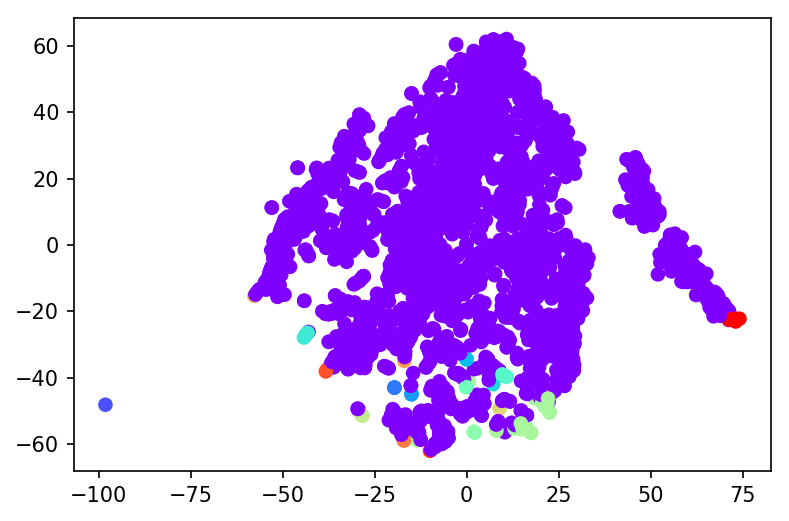

In [785]:
plt.figure(dpi=150)
plt.scatter(low_dim_nmf_cv[:,0], low_dim_nmf_cv[:,1], c=km.labels_, cmap=plt.cm.rainbow)
plt.show()

**NMF / TF-IDF**

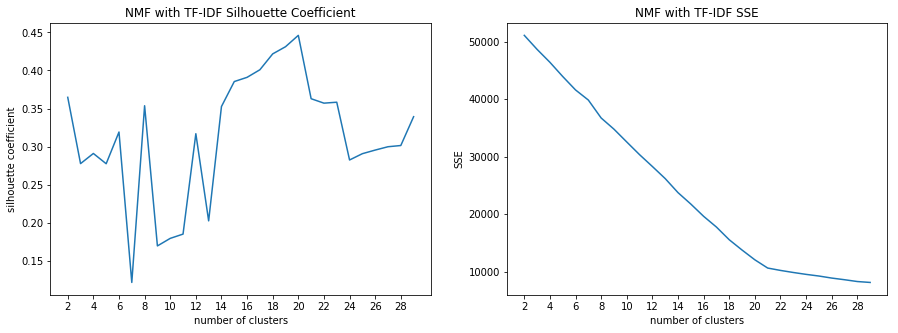

In [786]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_nmf_tfidf, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('NMF with TF-IDF Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('NMF with TF-IDF SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [787]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_nmf_tfidf)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_nmf_tfidf = tsne_model.fit_transform(ssx_nmf_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2680 samples in 0.006s...
[t-SNE] Computed neighbors for 2680 samples in 0.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2680
[t-SNE] Computed conditional probabilities for sample 2000 / 2680
[t-SNE] Computed conditional probabilities for sample 2680 / 2680
[t-SNE] Mean sigma: 0.395796
[t-SNE] Computed conditional probabilities in 0.090s
[t-SNE] Iteration 50: error = 76.6505966, gradient norm = 0.0609725 (50 iterations in 4.830s)
[t-SNE] Iteration 100: error = 70.0202560, gradient norm = 0.0083041 (50 iterations in 3.615s)
[t-SNE] Iteration 150: error = 69.4660721, gradient norm = 0.0071819 (50 iterations in 3.552s)
[t-SNE] Iteration 200: error = 69.2269363, gradient norm = 0.0052835 (50 iterations in 3.554s)
[t-SNE] Iteration 250: error = 69.1944962, gradient norm = 0.0022054 (50 iterations in 3.513s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.194496
[t-SNE] Iteration 300: erro

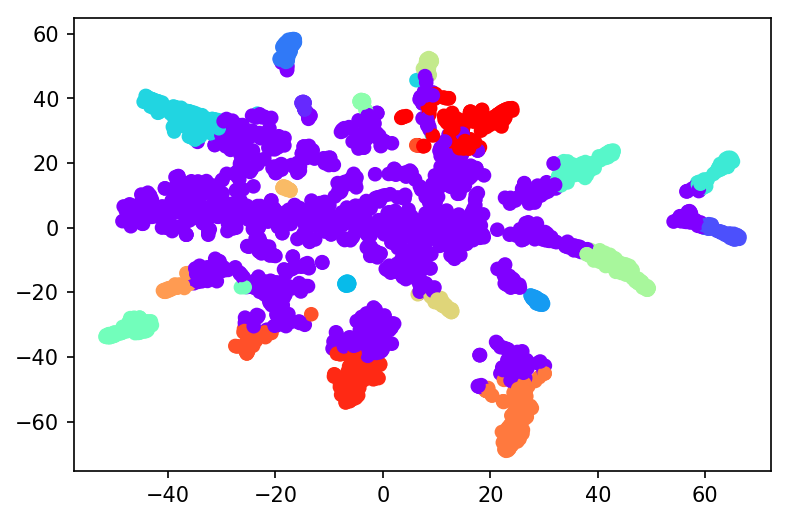

In [788]:
plt.figure(dpi=150)
plt.scatter(low_dim_nmf_tfidf[:,0], low_dim_nmf_tfidf[:,1], c=km.labels_, cmap=plt.cm.rainbow)
plt.show()

### LSA Clustering

**LSA / CV**

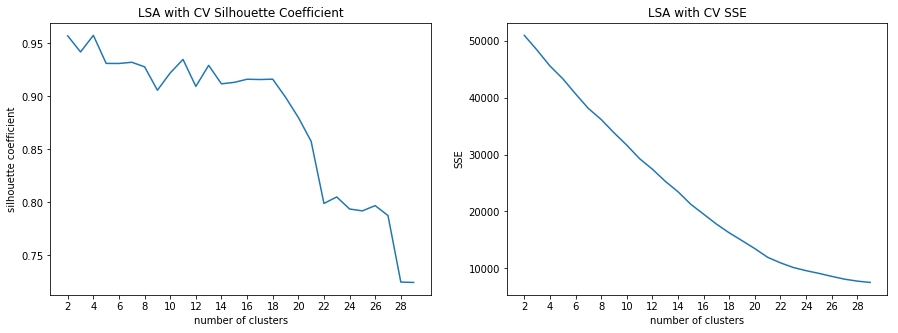

In [789]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_lsa_cv, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('LSA with CV Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('LSA with CV SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [790]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_lsa_cv)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_lsa_cv = tsne_model.fit_transform(ssx_lsa_cv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2680 samples in 0.002s...
[t-SNE] Computed neighbors for 2680 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2680
[t-SNE] Computed conditional probabilities for sample 2000 / 2680
[t-SNE] Computed conditional probabilities for sample 2680 / 2680
[t-SNE] Mean sigma: 0.007505
[t-SNE] Computed conditional probabilities in 0.115s
[t-SNE] Iteration 50: error = 79.0188065, gradient norm = 0.0356369 (50 iterations in 5.780s)
[t-SNE] Iteration 100: error = 73.5988083, gradient norm = 0.0035748 (50 iterations in 4.916s)
[t-SNE] Iteration 150: error = 73.5176392, gradient norm = 0.0007565 (50 iterations in 4.061s)
[t-SNE] Iteration 200: error = 73.5097046, gradient norm = 0.0002659 (50 iterations in 3.894s)
[t-SNE] Iteration 250: error = 73.5079803, gradient norm = 0.0001607 (50 iterations in 3.907s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.507980
[t-SNE] Iteration 300: erro

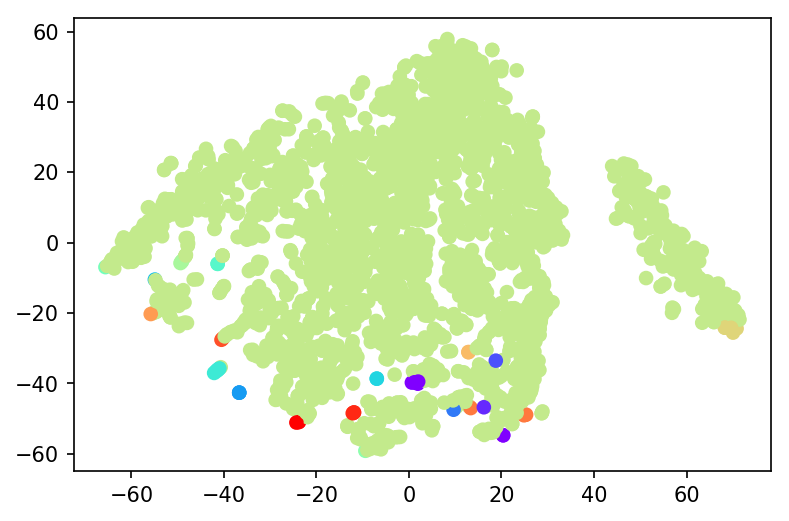

In [791]:
plt.figure(dpi=150)
plt.scatter(low_dim_lsa_cv[:,0], low_dim_lsa_cv[:,1], c=km.labels_, cmap=plt.cm.rainbow)
plt.show()

**LSA / TF-IDF**

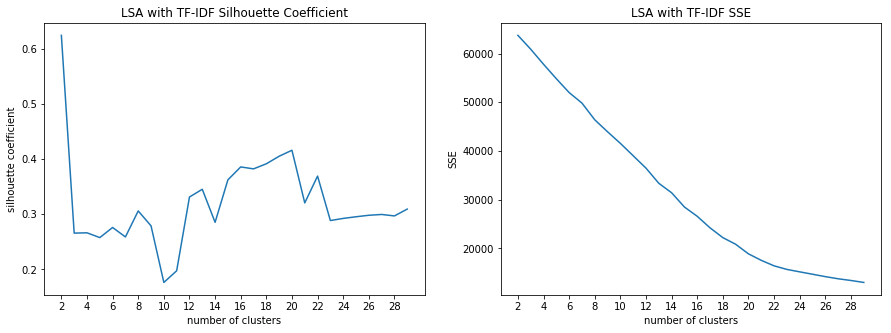

In [977]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_lsa_tfidf, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('LSA with TF-IDF Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('LSA with TF-IDF SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [978]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_lsa_tfidf)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_lsa_tfidf = tsne_model.fit_transform(ssx_lsa_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3350 samples in 0.008s...
[t-SNE] Computed neighbors for 3350 samples in 0.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3350
[t-SNE] Computed conditional probabilities for sample 2000 / 3350
[t-SNE] Computed conditional probabilities for sample 3000 / 3350
[t-SNE] Computed conditional probabilities for sample 3350 / 3350
[t-SNE] Mean sigma: 0.426517
[t-SNE] Computed conditional probabilities in 0.125s
[t-SNE] Iteration 50: error = 79.1136017, gradient norm = 0.0416856 (50 iterations in 6.345s)
[t-SNE] Iteration 100: error = 73.6996078, gradient norm = 0.0084820 (50 iterations in 4.597s)
[t-SNE] Iteration 150: error = 73.2236786, gradient norm = 0.0036915 (50 iterations in 4.438s)
[t-SNE] Iteration 200: error = 73.0532608, gradient norm = 0.0022689 (50 iterations in 4.466s)
[t-SNE] Iteration 250: error = 73.0253601, gradient norm = 0.0028390 (50 iterations in 4.691s)
[t-SNE] KL divergence after 250 iterati

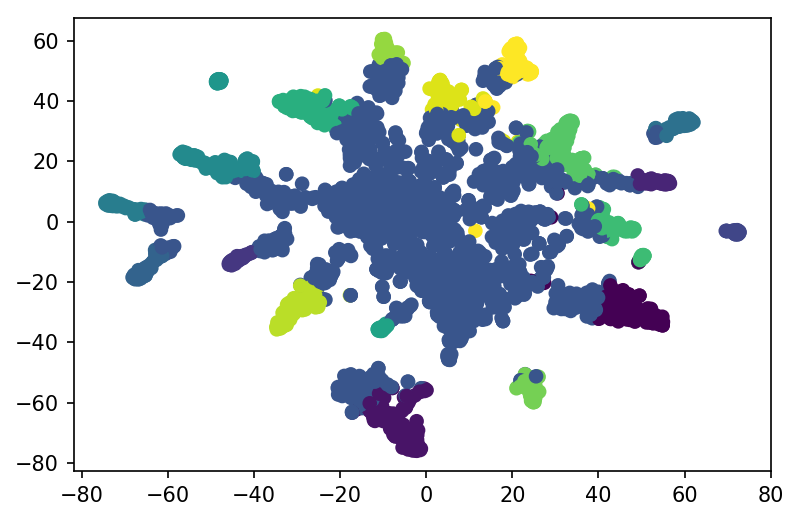

In [980]:
plt.figure(dpi=150)
plt.scatter(low_dim_lsa_tfidf[:,0], low_dim_lsa_tfidf[:,1], c=km.labels_, cmap=None)
plt.show()

### LDA Clustering

**LDA / CV**

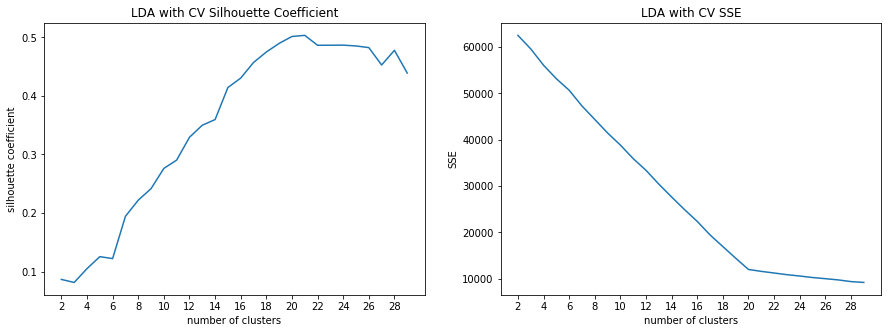

In [888]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_lda_cv, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('LDA with CV Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('LDA with CV SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [889]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_lda_cv)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_lda_cv = tsne_model.fit_transform(ssx_lda_cv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3350 samples in 0.013s...
[t-SNE] Computed neighbors for 3350 samples in 0.762s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3350
[t-SNE] Computed conditional probabilities for sample 2000 / 3350
[t-SNE] Computed conditional probabilities for sample 3000 / 3350
[t-SNE] Computed conditional probabilities for sample 3350 / 3350
[t-SNE] Mean sigma: 0.000873
[t-SNE] Computed conditional probabilities in 0.167s
[t-SNE] Iteration 50: error = 74.3716812, gradient norm = 0.0494402 (50 iterations in 6.906s)
[t-SNE] Iteration 100: error = 63.1586800, gradient norm = 0.0232926 (50 iterations in 4.773s)
[t-SNE] Iteration 150: error = 60.0008392, gradient norm = 0.0095375 (50 iterations in 4.204s)
[t-SNE] Iteration 200: error = 58.3827744, gradient norm = 0.0108354 (50 iterations in 4.245s)
[t-SNE] Iteration 250: error = 57.4080887, gradient norm = 0.0099149 (50 iterations in 4.884s)
[t-SNE] KL divergence after 250 iterati

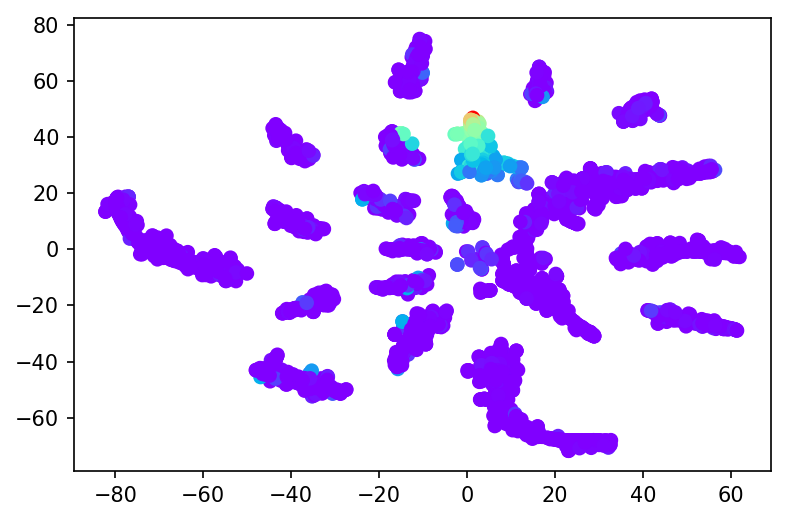

In [921]:
plt.figure(dpi=150)
plt.scatter(low_dim_lda_cv[:,0], low_dim_lda_cv[:,1], c=ssx_lda_cv[:,19], cmap=plt.cm.rainbow)
plt.show()

**LDA / TF-IDF**

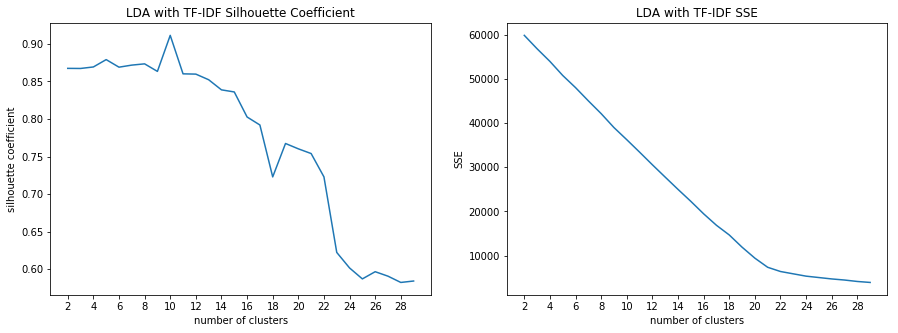

In [891]:
k_clusters, silhouette_coefs, sse = get_silhouette_sse(ssx_lda_tfidf, range(2,30))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

ax1.plot(k_clusters, silhouette_coefs)
ax1.set_title('LDA with TF-IDF Silhouette Coefficient')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 30, step=2))

# plot Inertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_title('LDA with TF-IDF SSE')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [892]:
km = KMeans(n_clusters=20, n_init=100, max_iter=1000, random_state=25)
ypred = km.fit_predict(ssx_lda_tfidf)

tsne_model = TSNE(n_components=2, random_state=25, verbose=2)
low_dim_lda_tfidf = tsne_model.fit_transform(ssx_lda_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3350 samples in 0.004s...
[t-SNE] Computed neighbors for 3350 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3350
[t-SNE] Computed conditional probabilities for sample 2000 / 3350
[t-SNE] Computed conditional probabilities for sample 3000 / 3350
[t-SNE] Computed conditional probabilities for sample 3350 / 3350
[t-SNE] Mean sigma: 0.005772
[t-SNE] Computed conditional probabilities in 0.165s
[t-SNE] Iteration 50: error = 71.5940399, gradient norm = 0.0392568 (50 iterations in 4.896s)
[t-SNE] Iteration 100: error = 60.3672218, gradient norm = 0.0176199 (50 iterations in 3.850s)
[t-SNE] Iteration 150: error = 56.9592705, gradient norm = 0.0158136 (50 iterations in 3.968s)
[t-SNE] Iteration 200: error = 54.8320656, gradient norm = 0.0174675 (50 iterations in 3.794s)
[t-SNE] Iteration 250: error = 53.4563370, gradient norm = 0.0088824 (50 iterations in 3.743s)
[t-SNE] KL divergence after 250 iterati

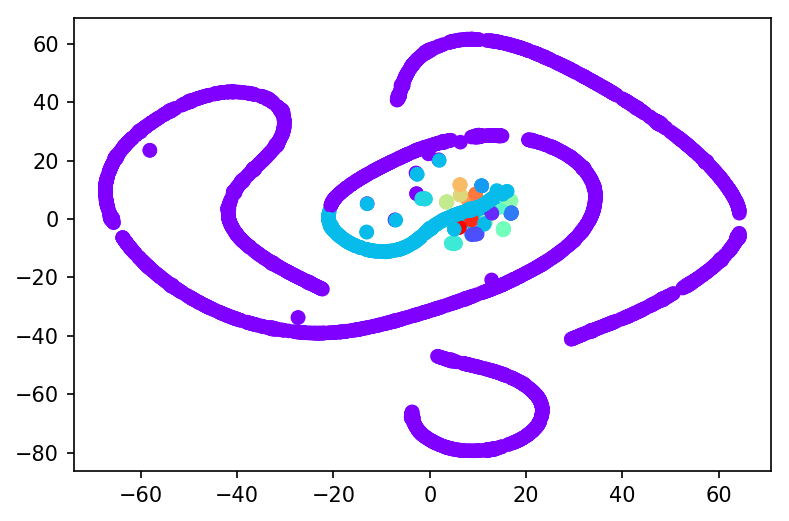

In [893]:
plt.figure(dpi=150)
plt.scatter(low_dim_lda_tfidf[:,0], low_dim_lda_tfidf[:,1], c=km.labels_, cmap=plt.cm.rainbow)
plt.show()

# Building Recommender

In [981]:
def get_recommendations(first_article, model, vectorizer, training_vectors):
    '''
    first_article: (string) An article that we want to use to find similar articles
    model: (a fit dimensionality reducer) Projects vectorized words onto a subspace 
           (uses NMF or SVD/LSA typically)
    vectorizer: Vectorizes first_article 
    training_vectors: (numpy array shape) a (num_docs in training) x (NMF/SVD/LSA) dimensional array.
                      Used to train NearestNeighbors model
    '''
    new_vec = model.transform(
        vectorizer.transform([first_article]))
    nn = NearestNeighbors(n_neighbors=100, metric='cosine', algorithm='brute')
    nn.fit(training_vectors)
    results = nn.kneighbors(new_vec)
    return results[1][0]


In [923]:
game_id_df[game_id_df.Title == 'The Legend of Zelda: Breath of the Wild']

,game_id,Title,Platform
2807,2808,The Legend of Zelda: Breath of the Wild,Switch
2808,2809,The Legend of Zelda: Breath of the Wild,WiiU


In [924]:
data_index = game_id_df[game_id_df.Title == 'The Legend of Zelda: Breath of the Wild'][game_id_df.Platform == 'Switch'].index[0]
train_data['reviews'][data_index]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


'version majora mask place gorgeous smart addicting hr force leave break wanna exploring experiencing beautifully crafted massive clearly change aspect 3d identity charm gorgeous smart addicting hr force leave break wanna exploring experiencing beautifully crafted massive clearly change aspect 3d identity charm everywhere subtle straight route second puzzle quest scenery top notch puzzle clever diverse surprising powerful present seriously doubt leave keep breath wild switch home wander searching place none disappointed doubt decade stop breath wild masterpiece launch title along 64 reason breath wild exploration imagine finish stop breath wild masterpiece launch title along 64 reason breath wild exploration imagine finish 100 breath wild skyward sword skyward sword stamen bar shield break item temple anymore avoid spoiler breath wild hardest die waited e3 2014 showed trailer disappointed incredible detail vast area scenery incredible surpassed ocarina immersion historical industry inc

In [982]:
new_datapoint = [train_data['reviews'][data_index]]
new_datapoint
new_vec = lsa.transform(tfidf_vectorizer.transform(new_datapoint))

nn = NearestNeighbors(n_neighbors=100, metric='cosine', algorithm='brute')
nn.fit(lsa_tfidf_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=100, p=2, radius=1.0)

In [974]:
result = nn.kneighbors(new_vec)
result[1][0]

array([2807, 2808, 2818,  517,  520,  518, 2814,  123, 2816, 2824, 1640,
       2381, 2852, 2821, 1957, 1917, 2461,  119, 3131,  515, 2372, 1916,
       1280, 2815,   10, 2813,  118, 2371, 1279, 2823, 1915,  124,  239,
       2578,  126,  693, 2726,  516, 1914, 1976, 3223,   66,  125, 2817,
       2812,  351, 1918, 2568, 2354, 3322,  110, 3132, 2375, 1919, 2579,
       2805, 1907, 3086, 1046,  355, 1145, 3182, 3104, 2937,  235,   71,
       1961, 3346,  350,  846,   70,  519, 1875, 3323, 2569, 2729, 2459,
       1921,  482, 1963, 2529, 2008,  845, 1049, 3345,  353,  848, 2727,
       2500, 2791, 1874, 2583, 1878,  741, 1520, 2822, 3222,  349, 2627,
       2544])

In [983]:
for r in result[1][0]:
    #g_id = train_data['game_id'][r]
    game = game_id_df.Title[r]
    plat = game_id_df.Platform[r]
    print(f'{game} on {plat}')


The Legend of Zelda: Breath of the Wild on Switch
The Legend of Zelda: Breath of the Wild on WiiU
The Legend of Zelda: Skyward Sword on Wii
Darksiders II on PC
Darksiders II on Xbox360
Darksiders II on PlayStation3
The Legend of Zelda: Ocarina of Time on Nintendo64
Banjo-Tooie on Nintendo64
The Legend of Zelda: Ocarina of Time 3D on 3DS
The Legend of Zelda: Twilight Princess on Wii
Minit on PlayStation4
Shantae: Risky's Revenge on DS
The Sexy Brutale on XboxOne
The Legend of Zelda: The Wind Waker on GameCube
Overlord on PC
Okami HD on PlayStation3
Skylanders: Spyro's Adventure on Wii
Baldur's Gate: Dark Alliance on Xbox
Undertale on PC
Darksiders on PlayStation3
Shadow of the Colossus on PlayStation4
Okami HD on PC
Journey on PlayStation4
The Legend of Zelda: Ocarina of Time / Master Quest on GameCube
ABZU on PC
The Legend of Zelda: Majora's Mask 3D on 3DS
Baldur's Gate: Dark Alliance on PlayStation2
Shadow of the Colossus on PlayStation2
Journey on PlayStation3
The Legend of Zelda: Tw